In [1]:
debug = 1
city = "Washington DC"
g = 0

show_year = 2018
scale = 0.25

check_tract_and_city_boundaries = True
check_tract_consistency = True
show_water = True

use_area_approximation = True
deg_to_m_at_equator = 111194.9
sq_deg_to_sq_m_at_equator = deg_to_m_at_equator ** 2  # One square degree ~~ 110,000*110,000 square meters at the equator


print('Importing packages...')
import os
import pandas
import numpy as np
import time
#import zipfile
import geopandas
from pprint import pprint
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Point

pandas.set_option('display.max_colwidth', -1)


# Directories to look in
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch_final/'
jobs_dir = data_dir + 'lodes_wac/'

#census_dir = data_dir + 'acs5/'

output_data_dir = thisdir + 'final_data/'
#baltimore_dir = thisdir + 'baltimore/'

census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

#shapefile_dir = census_shapefile_tiger_basedir + '{0:.0f}/TRACT/'.format(thisyear)

acs5_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'

code_lookup_dir = thisdir + 'code_guide_lookups/'
inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'
extrasdir = '/home/idies/workspace/Storage/raddick/census/extras/'

city_data_dir = thisdir + 'city_data/'


os.chdir(thisdir)
g = 0 # global time

print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


In [2]:
s = time.time()
years = np.arange(2018, 2009, -1)
equal_area_proj = {'init': 'epsg:2163'}   # https://epsg.io/2163
overlap_tolerance_square_meters = np.nan

if (city == 'Baltimore'):
    thestate = 24
    state_abbrev = 'md'
    citycode = 4000
    baltimore_shapefile_dir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
    overlap_tolerance_square_meters = 10
    #plotlimits = {'N': 39.4, 'S': 39.15, 'E': -76.5, 'W': -76.75}
    plotlimits = {'N': 39.275, 'S': 39.325, 'E': -76.53, 'W': -76.55}

elif (city == 'Washington DC'):
    thestate = 11   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'dc'
    citycode = 50000
    overlap_tolerance_square_meters = 10
    plotlimits = {'N': 39.01, 'S': 38.79, 'E': -76.9, 'W': -77.13}

elif (city == 'Detroit'):
    thestate = 26   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'mi'
    citycode = 22000
    plotlimits = {'N': 42.5, 'S': 42.2, 'E': -82.8, 'W': -83.3}
    
elif (city == 'Newark'):
    thestate = 34
    state_abbrev = 'nj'
    citycode = 51000
    
elif (city == 'St. Louis'):
    thestate = 29   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'mo'
    citycode = 65000
#    cityname_file = 'st_louis'
    
elif (city == 'Richmond'):
    thestate = 47   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'va'
    citycode = 67000
    #thecounty = 760
#    cityname_file = 'richmond'
    
elif (city == 'San Francisco'):
    thestate = 5   # state_codes_df[state_codes_df['STATE_NAME'] == 'California']
    state_abbrev = 'ca'
    #thecounty = 75
    citycode = 67000
    cityname_file = 'san_francisco'
    
elif (city == 'Pittsburgh'):
    thestate = 42
    state_abbrev = 'pa'
    citycode = 61000

elif (city == 'Cleveland'):
    thestate = 39
    state_abbrev = 'oh'
    citycode = 16000
    plotlimits = {'N': 41.65, 'S': 41.35, 'E': -81.5, 'W': -81.9}
    
elif (city == 'Philadelphia'):
    thestate = 42
    state_abbrev = 'pa'
    #thecounty = 101
    citycode = 60000
    plotlimits = {'N': 40.15, 'S': 39.85, 'E': -74.93, 'W': -75.3}
else:
    print('ERROR: Select city from list!')

cityname_file = city.lower().replace(' ','_')
e = time.time()
g = g + (e-s)
print('Selected {0:}!'.format(city))

Selected Washington DC!


# Read census tracts and place files for this state


In [3]:
s = time.time()
debug = 1

state_tracts_gdf = pandas.DataFrame()
state_places_gdf = pandas.DataFrame()

print('Parsing tracts and places in {0:}...'.format(state_abbrev))
for thisyear in years:
    if (debug >= 1):
        print('\tParsing {0:.0f} census tracts and places in {1:}...'.format(thisyear, state_abbrev))

    if (thisyear == 2010):
        state_tracts_this_year_gdf = geopandas.GeoDataFrame()
        state_places_this_year_gdf = geopandas.GeoDataFrame()
        tractfiles = [
            census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)+x 
            for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)) 
            if (
                (x[-4:] == '.shp')
                and ('tl_{0:.0f}_{1:02d}'.format(thisyear,thestate) in x)
            )
        ]
        placefiles = [
            census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear)+x 
            for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear))
            if (
                (x[-4:] == '.shp')
                and 
                ('tl_2010_{0:.0f}'.format(thestate) in x)
            )
        ]

        for i in range (0, len(tractfiles)):
            state_tracts_this_year_gdf = pandas.concat((state_tracts_this_year_gdf, geopandas.read_file(tractfiles[i])), axis=0, sort=False)
        for j in range (0, len(placefiles)):
            state_places_this_year_gdf = pandas.concat((state_places_this_year_gdf, geopandas.read_file(placefiles[j])), axis=0, sort=False)
        tract_new_column_names = []
        for k in state_tracts_this_year_gdf.columns.tolist():
            if ('10' in k):
                tract_new_column_names.append(k[0:-2])
            else:
                tract_new_column_names.append(k)
        place_new_column_names = []
        for m in state_places_this_year_gdf.columns.tolist():
            if ('10' in m):
                place_new_column_names.append(m[0:-2])
            else:
                place_new_column_names.append(m)
        state_tracts_this_year_gdf.columns = tract_new_column_names
        state_places_this_year_gdf.columns = place_new_column_names
    else:
        state_tracts_this_year_gdf = geopandas.read_file(census_shapefile_tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_{1:02d}_tract.shp'.format(thisyear, thestate))
        state_places_this_year_gdf = geopandas.read_file(census_shapefile_tiger_basedir + '{0:.0f}/PLACE/tl_{0:.0f}_{1:.0f}_place.shp'.format(thisyear, thestate))

    state_tracts_this_year_gdf = state_tracts_this_year_gdf.assign(year = thisyear)
    state_places_this_year_gdf = state_places_this_year_gdf.assign(year = thisyear)

    state_tracts_gdf = pandas.concat((state_tracts_gdf, state_tracts_this_year_gdf), axis=0, sort=False)
    state_places_gdf = pandas.concat((state_places_gdf, state_places_this_year_gdf), axis=0, sort=False)

state_tracts_gdf = state_tracts_gdf.reindex()
state_places_gdf = state_places_gdf.reindex()

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} tract-years and {1:,.0f} place-years in {2:} in {3:,.0f} minutes {4:,.0f} seconds!'.format(len(state_tracts_gdf), len(state_places_gdf), state_abbrev, np.floor((e-s)/60), (e-s)%60))


Parsing tracts and places in dc...
	Parsing 2018 census tracts and places in dc...
	Parsing 2017 census tracts and places in dc...
	Parsing 2016 census tracts and places in dc...
	Parsing 2015 census tracts and places in dc...
	Parsing 2014 census tracts and places in dc...
	Parsing 2013 census tracts and places in dc...
	Parsing 2012 census tracts and places in dc...
	Parsing 2011 census tracts and places in dc...
	Parsing 2010 census tracts and places in dc...
Read 1,790 tract-years and 9 place-years in dc in 0 minutes 2 seconds!


# Step 1: do the tract boundaries line up with city boundaries?

## Step 1a: can we trust the approximate area calculations?

In [4]:
s = time.time()
if (np.isnan(overlap_tolerance_square_meters)):
    print('First, can we approximate the physical area by converting from square degrees to save time?')

    
    for thisyear in years:
        if (debug >= 2):
            print('calculating area in square meters using re-projection...')
        this_city_gdf = geopandas.GeoDataFrame(state_places_gdf[
            (state_places_gdf['GEOID'] == '{0:02d}{1:05d}'.format(thestate,citycode))
        ], crs=state_places_gdf.crs)
        area_sq_m = this_city_gdf[this_city_gdf['year'] == thisyear].to_crs(equal_area_proj).geometry.area.values[0]
        if (debug >= 2):
            print('\tUsing equal-area reprojection: {0:} ({1:.0f}): area is {2:,.0f} square meters.'.format(city,thisyear,area_sq_m))
        if (debug >= 2):
            print('calculating area in square meters using approximate formula...')
        city_centroid_lat = this_city_gdf[this_city_gdf['year'] == thisyear].geometry.apply(lambda x: x.centroid.coords[0]).values[0][1]
        area_sq_deg = this_city_gdf.geometry.area.values[0]
        conversion_factor = sq_deg_to_sq_m_at_equator * np.cos(np.deg2rad(city_centroid_lat))

        if (debug >= 2):
            print('\t\t area using approximation: {0:,.0f} square meters.'.format(area_sq_deg*conversion_factor))
        if (debug >= 1):
            print('{0:} ({1:.0f}): Approximation is accurate to {2:%} percent.'.format(city, thisyear, (area_sq_m - (area_sq_deg*conversion_factor))/area_sq_m))
        if (debug >= 2):
            print('\n')
    #print(area_sq_deg)
else:
    print('already found overlap tolerance for {0:}: {1:,.1f} sqaure meters'.format(city, overlap_tolerance_square_meters))
e = time.time()
g = g + (e-s)
print('Done in {0:,.2f} seconds!'.format(e-s))


already found overlap tolerance for Washington DC: 10.0 sqaure meters
Done in 0.00 seconds!


## Step 1b: What's the best area overlap tolerance to determine if tracts end at city border?

In [5]:
s = time.time()

if (np.isnan(overlap_tolerance_square_meters)):
    #use_area_approximation = True

    print('Identifying tracts with possible overlaps...')
    show_year_maybe_city_tracts_gdf = state_tracts_gdf[
        (state_tracts_gdf.geometry.apply(lambda x: x.intersects(this_city_gdf[this_city_gdf['year'] == show_year].geometry.values[0])))
        & (state_tracts_gdf['year'] == show_year)
    ]

    print('Calcluating and displaying overlap areas...')
    city_centroid_lat = this_city_gdf[this_city_gdf['year'] == thisyear].geometry.apply(lambda x: x.centroid.coords[0]).values[0][1]
    conversion_factor = sq_deg_to_sq_m_at_equator * np.cos(np.deg2rad(city_centroid_lat))

    if (use_area_approximation):
        pprint(
            show_year_maybe_city_tracts_gdf.geometry.apply(lambda x: (x.intersection(this_city_gdf[this_city_gdf['year'] == show_year].geometry.values[0]).area)*conversion_factor).sort_values().tolist()
        )
        # Baltimore: cutoff is at 155,076 square meters    
    else:
        pprint(show_year_maybe_city_tracts_gdf.to_crs(equal_area_proj).geometry.apply(lambda x: x.intersection(this_city_gdf[this_city_gdf['year'] == show_year].to_crs(equal_area_proj).geometry.values[0]).area).sort_values().tolist())
        # Baltimore: cutoff is at 155,102 square meters
else:
    print('already found overlap tolerance for {0:}: {1:,.1f} sqaure meters'.format(city, overlap_tolerance_square_meters))

e = time.time()
g = g + (e-s)
print('Done in {0:.1f} seconds!'.format(e-s))


already found overlap tolerance for Washington DC: 10.0 sqaure meters
Done in 0.0 seconds!


## Step 1c: Identify which tracts are in the city and plot to make sure 

Washington DC (2010): Finding all tracts that overlap the city by at least 10.0 square meters...
plotting...
reading water files...
	reading water file 1 of 1...
Done in 18 seconds!


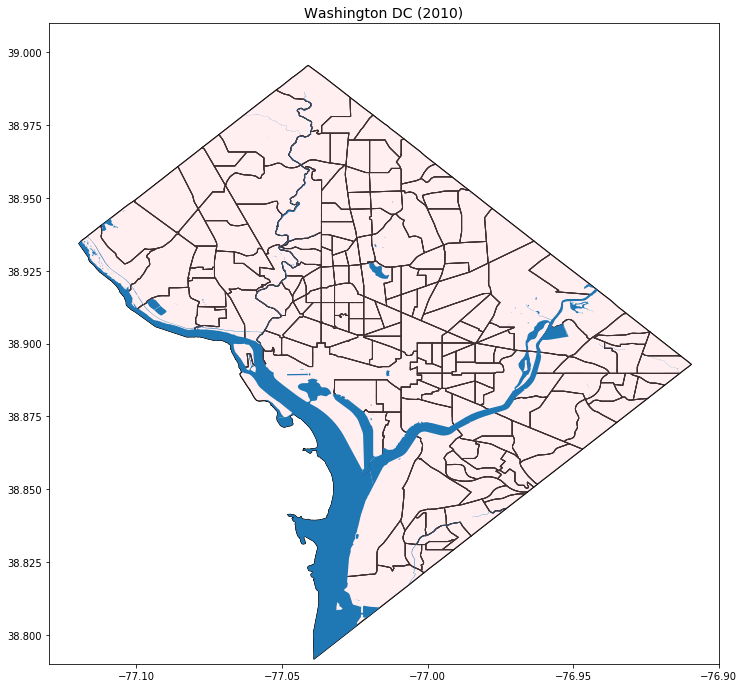

In [6]:
s = time.time()
show_year = 2010

maybe_this_city_this_year_gdf = geopandas.GeoDataFrame(state_places_gdf[
    (state_places_gdf['year'] == show_year)
    & (state_places_gdf['GEOID'] == '{0:02d}{1:05d}'.format(thestate,citycode))
], crs=state_places_gdf.crs)


if (overlap_tolerance_square_meters == 1):
    print('{0:} ({1:.0f}): Finding all tracts that overlap the city by at least {2:,.1f} square meter...'.format(city, show_year, overlap_tolerance_square_meters))
else:
    print('{0:} ({1:.0f}): Finding all tracts that overlap the city by at least {2:,.1f} square meters...'.format(city, show_year, overlap_tolerance_square_meters))

# Find intersection area directly in meters (much slower)

if (use_area_approximation):
    city_centroid_lat = maybe_this_city_this_year_gdf.geometry.apply(lambda x: x.centroid.coords[0][1]).values[0]
    conversion_factor = sq_deg_to_sq_m_at_equator * np.cos(np.deg2rad(city_centroid_lat))
    city_tracts_this_year_gdf = state_tracts_gdf[
        (state_tracts_gdf['year'] == show_year)
        & 
        (state_tracts_gdf.geometry.apply(lambda x: (x.intersection(maybe_this_city_this_year_gdf[maybe_this_city_this_year_gdf['year'] == show_year].geometry.values[0]).area)*conversion_factor) >= overlap_tolerance_square_meters)
    ]
else:
    city_tracts_this_year_gdf = state_tracts_gdf[
        (state_tracts_gdf['year'] == show_year)
        & 
        (state_tracts_gdf.to_crs(equal_area_proj).geometry.apply(lambda x: x.intersection(maybe_this_city_this_year_gdf.to_crs(equal_area_proj).geometry.values[0]).area >= overlap_tolerance_square_meters))
    ]


print('plotting...')
fig, ax = plt.subplots(1,1,figsize=(48*scale,48*scale))

city_tracts_this_year_gdf.plot(ax=ax, color='none', edgecolor='black')
maybe_this_city_this_year_gdf.plot(ax=ax, color='pink', alpha=0.25)

if (show_water):
    print('reading water files...')
    water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/".format(show_year)
    water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(show_year,thestate) in x) and (x[-3:] == 'shp')]
    water_gdf = geopandas.GeoDataFrame()
    for i in range(0, len(water_files)):
        if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
    water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
    water_gdf.plot(ax=ax)


plt.xlim([plotlimits['W'], plotlimits['E']])
plt.ylim([plotlimits['S'], plotlimits['N']])
plt.title('{0:} ({1:.0f})'.format(city, show_year), size=56*scale)


e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} seconds!'.format(e-s))

plt.show()


# Step 2: Are tract borders consistent across years?

## Step 2a: find city tracts for all years

In [7]:
s = time.time()
oneyear = 2018
#otheryear = 2010

city_tracts_years_gdf = geopandas.GeoDataFrame()

# if (overlap_tolerance_square_meters == 1):
#     print('{0:} ({1:.0f}): Finding all tracts that overlap the city by at least {2:,.1f} square meter...'.format(city, thisyear, overlap_tolerance_square_meters))
# else:
#     print('{0:} ({1:.0f}): Finding all tracts that overlap the city by at least {2:,.1f} square meters...'.format(city, thisyear, overlap_tolerance_square_meters))

for thisyear in years:
    print('Finding {0:} city tracts in {1:.0f}...'.format(city, thisyear))
    maybe_this_city_this_year_gdf = geopandas.GeoDataFrame(state_places_gdf[
        (state_places_gdf['year'] == thisyear)
        & (state_places_gdf['GEOID'] == '{0:02d}{1:05d}'.format(thestate,citycode))
    ], crs=state_places_gdf.crs)

    if (use_area_approximation):
        city_centroid_lat = maybe_this_city_this_year_gdf.geometry.apply(lambda x: x.centroid.coords[0][1]).values[0]
        conversion_factor = sq_deg_to_sq_m_at_equator * np.cos(np.deg2rad(city_centroid_lat))
        city_tracts_this_year_gdf = state_tracts_gdf[
            (state_tracts_gdf['year'] == thisyear)
            & 
            (state_tracts_gdf.geometry.apply(lambda x: (x.intersection(maybe_this_city_this_year_gdf[maybe_this_city_this_year_gdf['year'] == thisyear].geometry.values[0]).area)*conversion_factor) >= overlap_tolerance_square_meters)
        ]
    else:
        city_tracts_this_year_gdf = state_tracts_gdf[
            (state_tracts_gdf['year'] == thisyear)
            & 
            (state_tracts_gdf.to_crs(equal_area_proj).geometry.apply(lambda x: x.intersection(maybe_this_city_this_year_gdf.to_crs(equal_area_proj).geometry.values[0]).area >= overlap_tolerance_square_meters))
        ]
    city_tracts_this_year_gdf = city_tracts_this_year_gdf.assign(year = thisyear)
    city_tracts_years_gdf = pandas.concat((city_tracts_years_gdf, city_tracts_this_year_gdf), axis=0, sort=False)

for x in ['COUNTYFP','NAME','year']:
    city_tracts_years_gdf.loc[:, x] = pandas.to_numeric(city_tracts_years_gdf[x], errors='coerce')
city_tracts_years_gdf = city_tracts_years_gdf.set_index(['COUNTYFP','NAME','year'])

# print('backing up...')
# city_tracts_years_gdf_bk = city_tracts_years_gdf

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} seconds!'.format(e-s))
#city_tracts_gdf.sample(1).T

Finding Washington DC city tracts in 2018...
Finding Washington DC city tracts in 2017...
Finding Washington DC city tracts in 2016...
Finding Washington DC city tracts in 2015...
Finding Washington DC city tracts in 2014...
Finding Washington DC city tracts in 2013...
Finding Washington DC city tracts in 2012...
Finding Washington DC city tracts in 2011...
Finding Washington DC city tracts in 2010...
Done in 170 seconds!


## Step 2b: have any tracts changed names?

In [8]:
s = time.time()
print('getting from backup...')
counties_list = city_tracts_years_gdf.index.get_level_values('COUNTYFP').drop_duplicates().tolist()

print('{0:} covers {1:,.0f} county...'.format(city, len(counties_list)))
#print(counties_list)
for x in counties_list:
    print('County {0:,.0f} contains {1:,.0f} tract-years:'.format(x, len(city_tracts_years_gdf.reset_index()['COUNTYFP'] == x)))
    for i in years:
        print('{0:.0f}: {1:,.0f} tracts'.format(
            i, 
            len(city_tracts_years_gdf.reset_index()[
                (city_tracts_years_gdf.reset_index()['COUNTYFP'] == x) 
                & (city_tracts_years_gdf.reset_index()['year'] == i)])
        ))
        census_tracts_oneyear_list = city_tracts_years_gdf.xs(oneyear, level=-1).reset_index()[city_tracts_years_gdf.xs(oneyear, level=-1).reset_index()['COUNTYFP'] == x].set_index('NAME').index.values.tolist()
        county_x_year_i_census_tracts_list = city_tracts_years_gdf.reset_index()[
            (city_tracts_years_gdf.reset_index()['COUNTYFP'] == x) 
            & (city_tracts_years_gdf.reset_index()['year'] == i)
        ]['NAME'].tolist()

        new_census_tracts = []
        missing_census_tracts = []

        for n in county_x_year_i_census_tracts_list:
            if (n not in census_tracts_oneyear_list):
                new_census_tracts.append(n)
            for p in census_tracts_oneyear_list:
                if (p not in county_x_year_i_census_tracts_list):
                    missing_census_tracts.append(n)
        for y in new_census_tracts:
            print('Found census tract in {0:.0f} that is not present in 2018: {1:}'.format(i,y))
        for z in missing_census_tracts:
            print('Found census tract from 2018 that was not present in {0:.0f}: {1:}'.format(i,z))
        if (len(new_census_tracts) + len(missing_census_tracts) > 0):
            print('\n')

# fig, ax = plt.subplots(1,1, figsize=(48*scale,48*scale))

# city_tracts_years_gdf.xs(otheryear, level=-1).plot(ax=ax, color='none', edgecolor='red')
# city_tracts_years_gdf.xs(oneyear, level=-1).plot(ax=ax, color='none', edgecolor='black')


# # #city_tracts_years_gdf.loc[[2012, 35, 1711.03]].geometry.plot()#.plot(color='red')
# for ix, thisrow in city_tracts_years_gdf.xs(otheryear, level=-1).iterrows():
#     if (ix[1] in new_census_tracts):
#         annotator = ix[1]
#         ax.annotate(annotator, 
#                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                    xytext=(thisrow.geometry.centroid.x,#+0.01*np.random.rand(), 
#                            thisrow.geometry.centroid.y),#+0.01*np.random.rand()), 
#                    backgroundcolor = 'white', horizontalalignment='center', verticalalignment='center',
#                    fontsize=24*scale)

# plt.xlim([plotlimits['W'], plotlimits['E']])
# plt.ylim([plotlimits['S'], plotlimits['N']])
# plt.title('{0:.0f} (black) vs {1:.0f} (red)'.format(oneyear, otheryear), size=24)

# plt.show()
e = time.time()
g = g + (e-s)
print('Checked consistency of {0:,.0f} tract-year names in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(city_tracts_years_gdf), np.floor((e-s)/60), (e-s)%60))


getting from backup...
Washington DC covers 1 county...
County 1 contains 1,790 tract-years:
2018: 179 tracts
2017: 179 tracts
2016: 179 tracts
2015: 179 tracts
2014: 179 tracts
2013: 179 tracts
2012: 179 tracts
2011: 179 tracts
2010: 358 tracts
Checked consistency of 1,790 tract-year names in 0 minutes 1 seconds!
